In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from gp_utils import get_kernel
from phase_ucb import phase_ucb_likelihood_single, single_model, vectorize_responses

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
pos_linear = normalized_functions_dict['neg_quad']
pos_linear_kern = kernel_dict['pos_linear']
sinc_compressed = normalized_functions_dict['sinc_compressed']
sinc_compressed_kern = kernel_dict['sinc_compressed']

In [4]:
actions = np.array([np.array(r) for r in results['response']])
function_conditions = results['function_name'].values
kerns = [kernel_dict[function_conditions[i]] for i in range(len(actions))]
functions = [functions_dict[function_conditions[i]] for i in range(len(actions))]
rewards = np.array([normalized_functions_dict[function_conditions[i]][actions[i]] for i in range(len(actions))])

In [25]:
choices = np.arange(len(neg_quad))
trials = np.arange(len(actions.T))

In [6]:
vectorized_actions = [vectorize_responses(actions[i], rewards[i], choices, kerns[i]) for i in range(len(actions))]

In [69]:
all_samples = pd.read_csv('all_samples.csv')
all_samples = all_samples.sort_values('participant')

In [70]:
position = trials[None,:] - all_samples['x_midpoint__0'].values[:,None]
growth = np.exp(-all_samples['steepness__0'][:,None] * position)
denom = 1 + all_samples['yscale__0'][:,None] * growth
explore = 1 - 1. / denom

In [71]:
for i in range(len(explore.T)):
    all_samples['trial_'+str(i)] = explore.T[i]

In [72]:
means = all_samples.groupby('participant').mean()
stds = all_samples.groupby('participant').std()

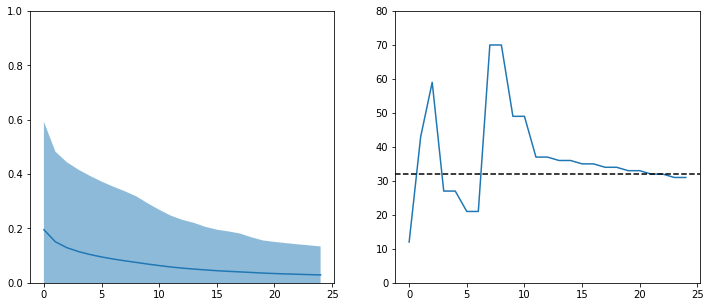

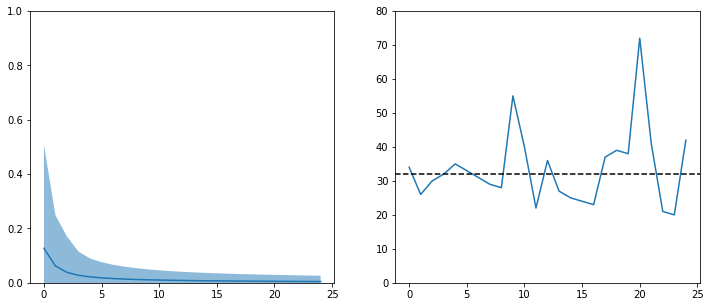

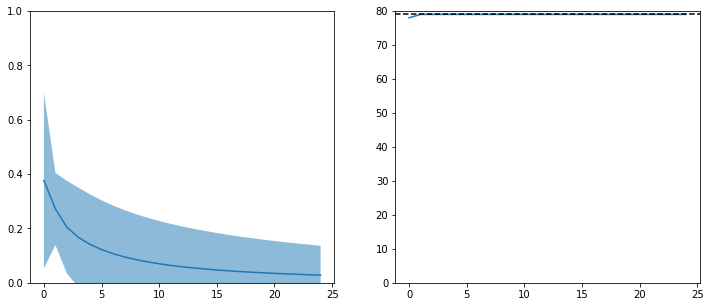

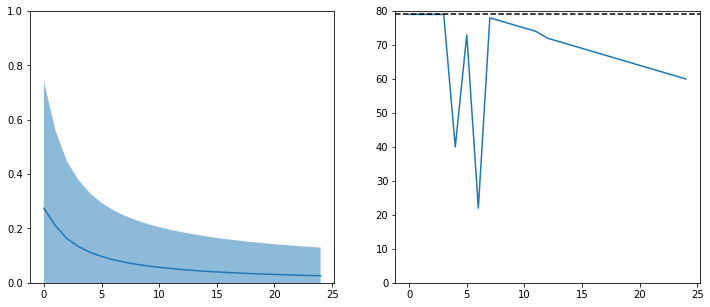

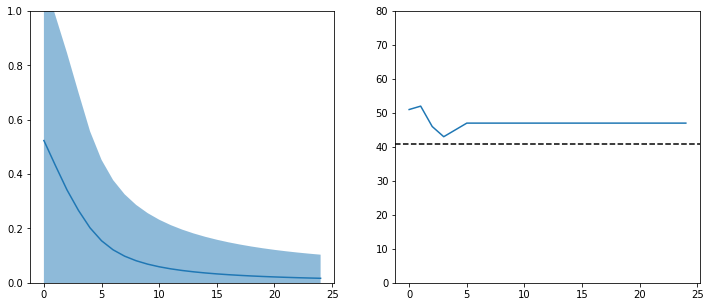

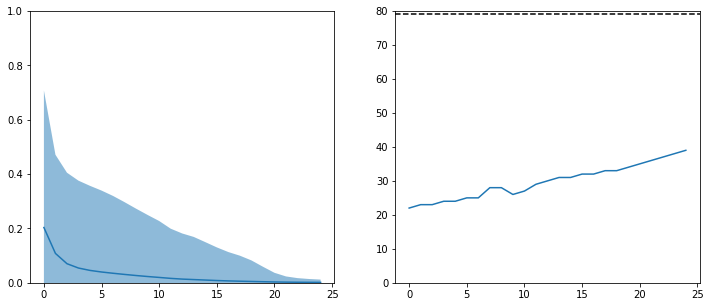

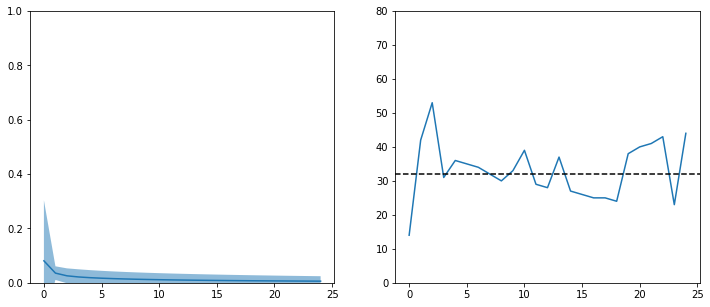

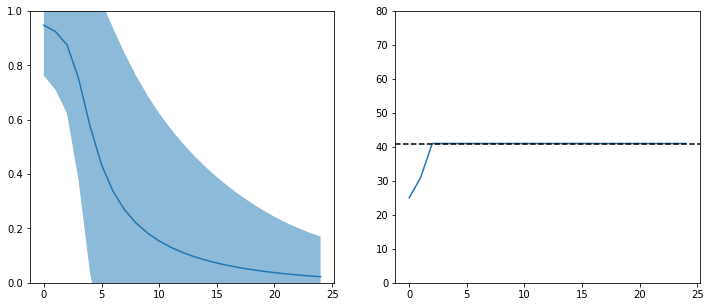

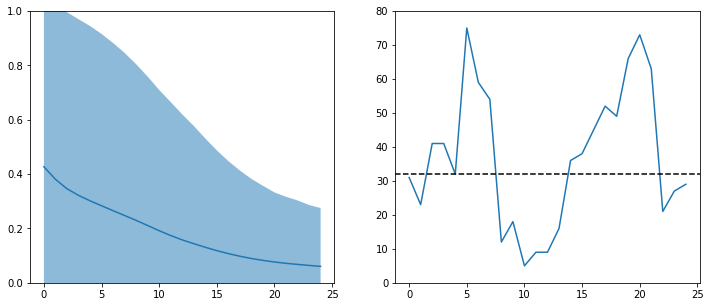

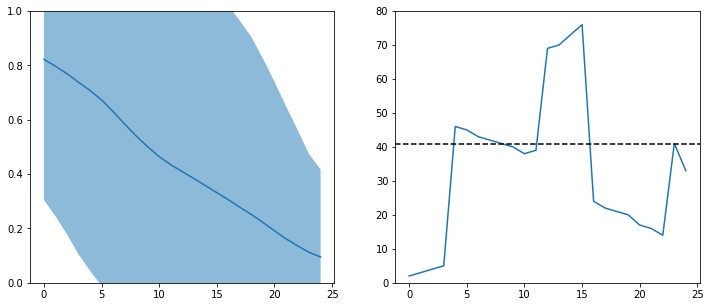

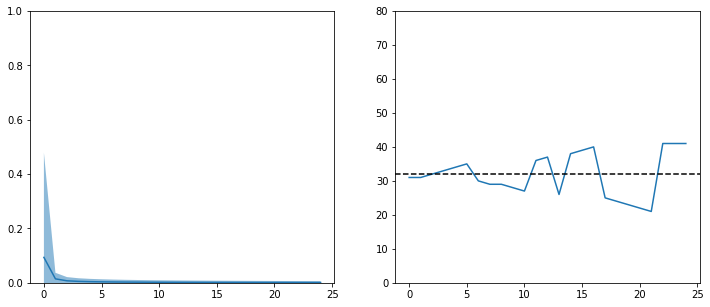

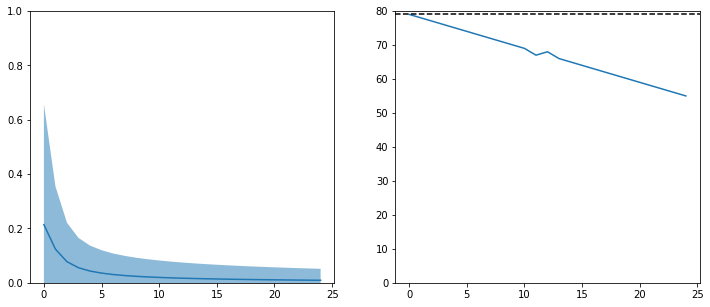

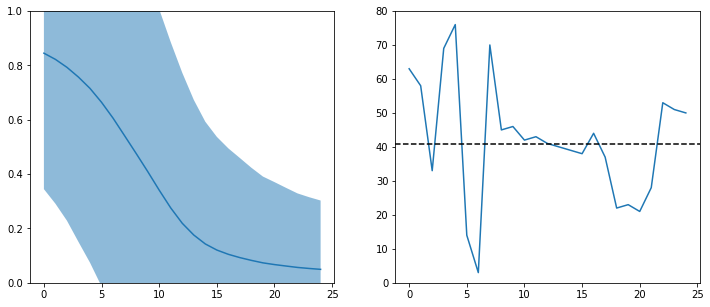

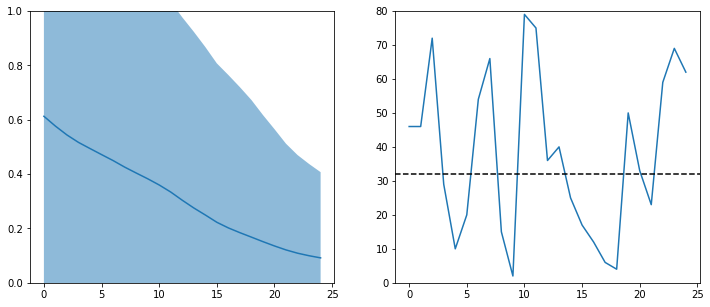

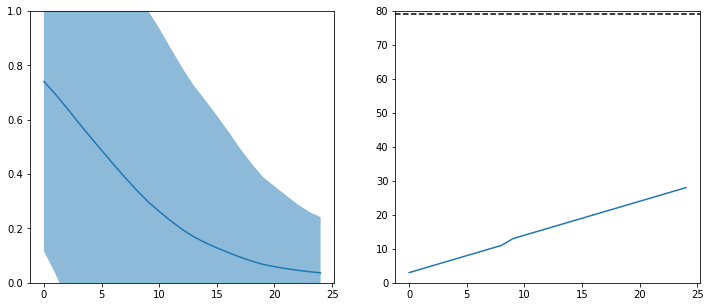

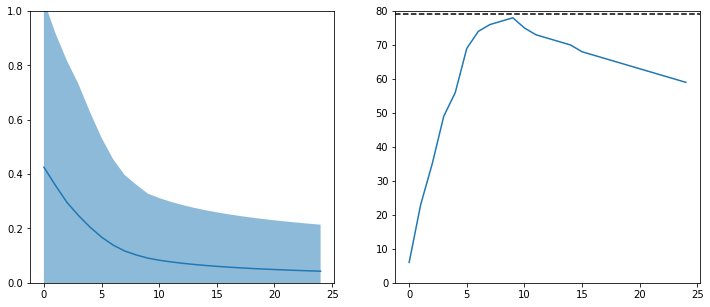

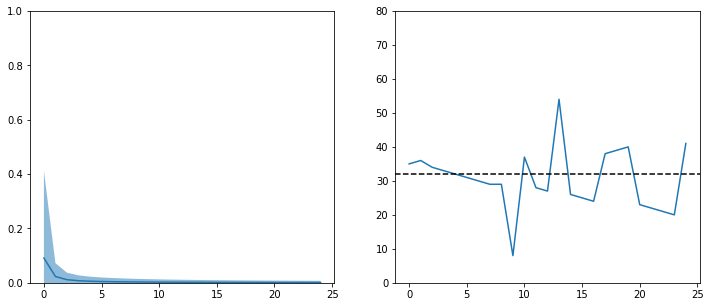

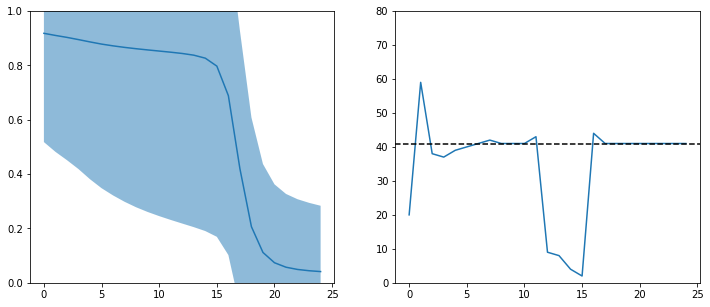

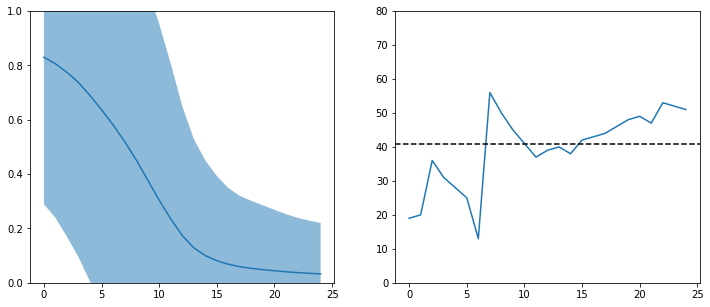

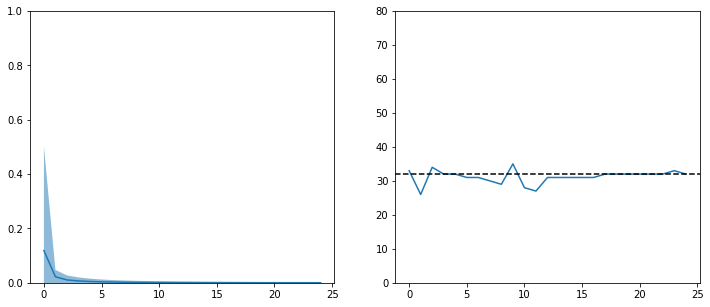

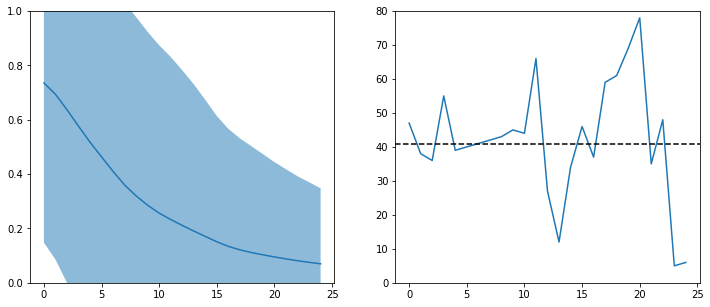

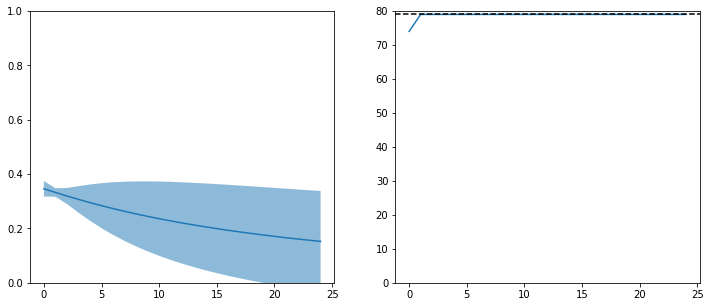

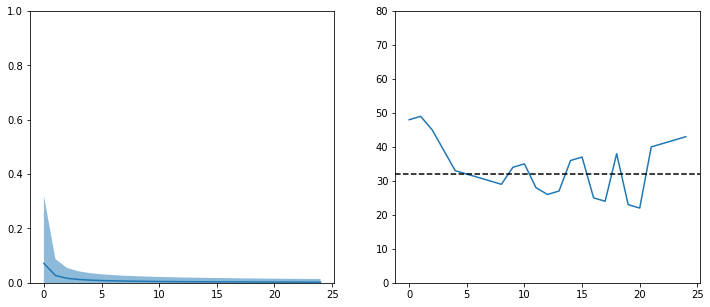

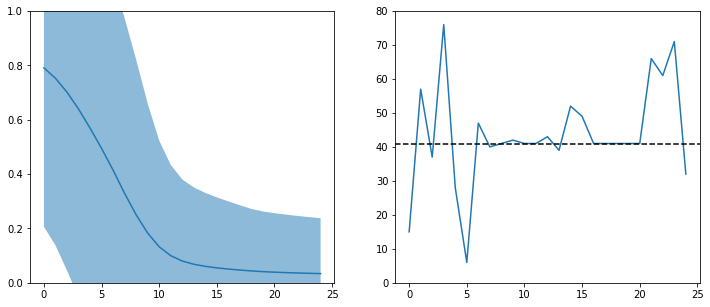

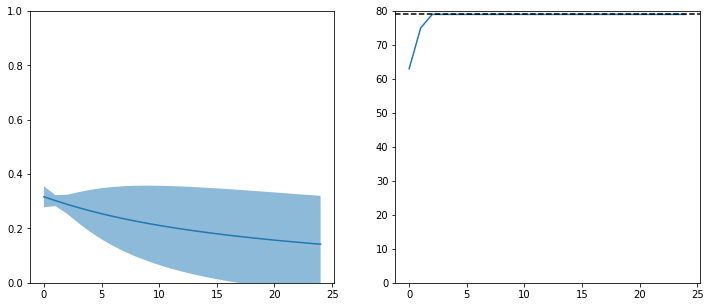

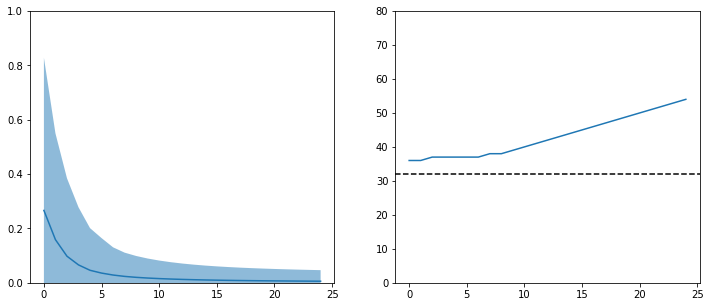

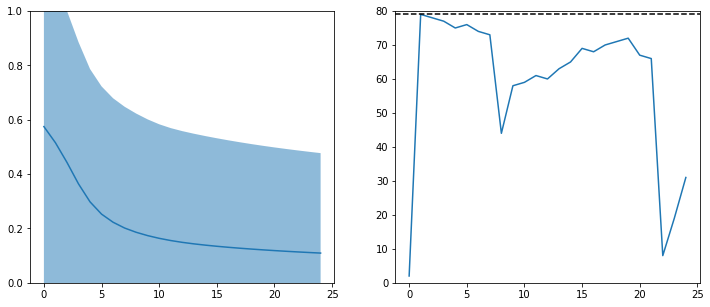

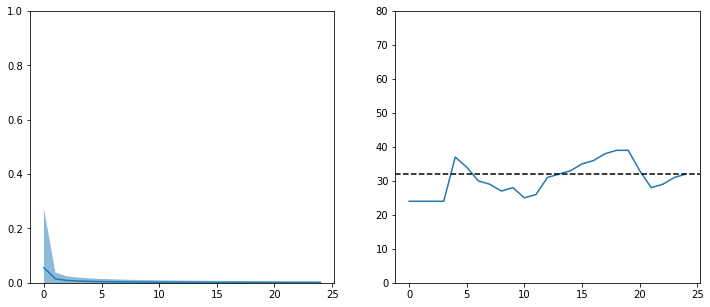

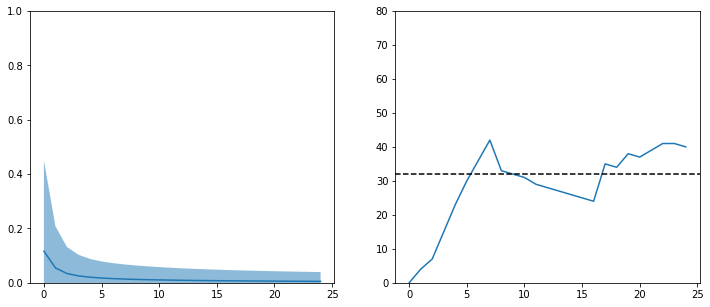

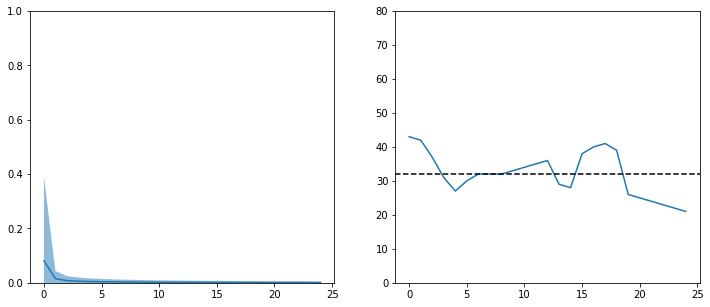

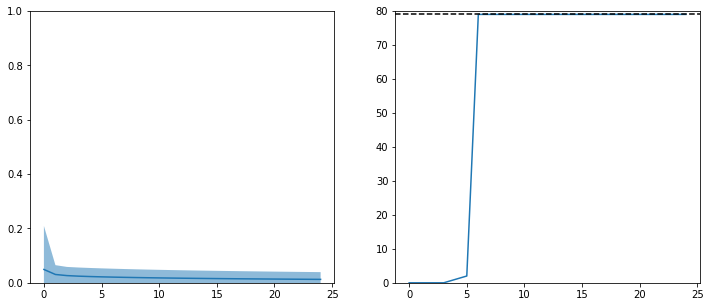

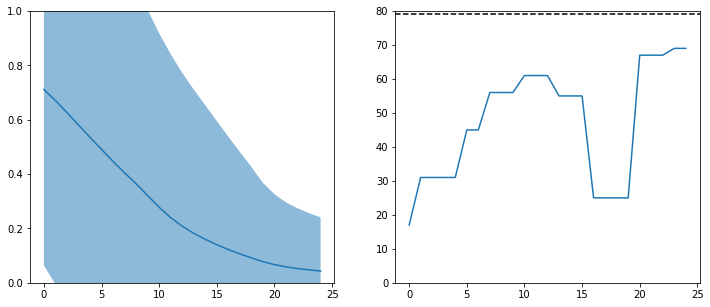

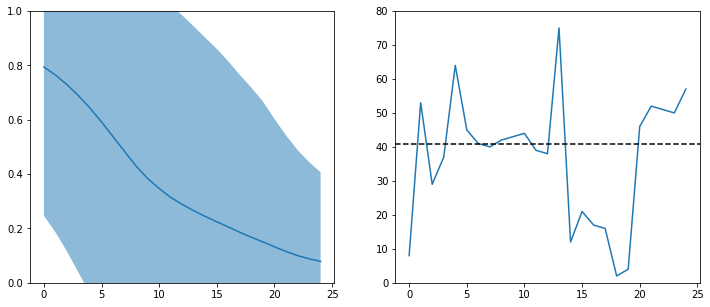

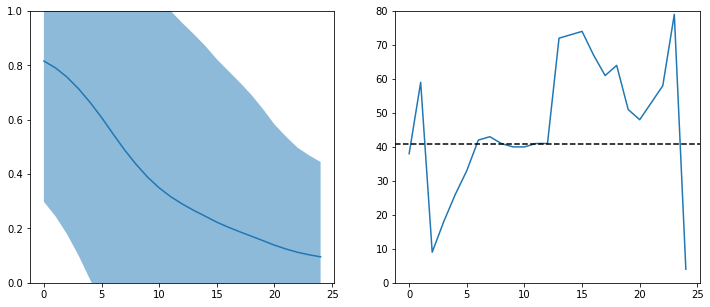

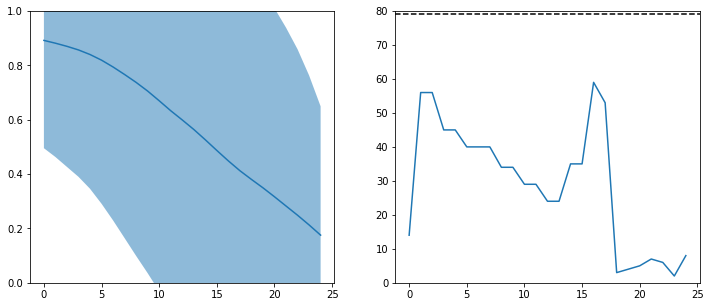

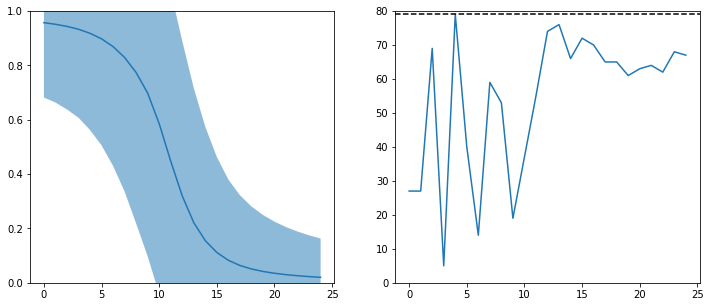

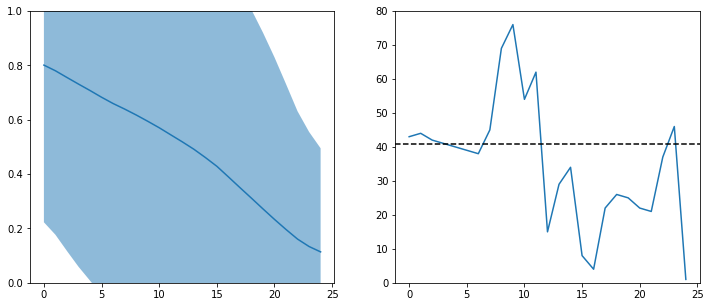

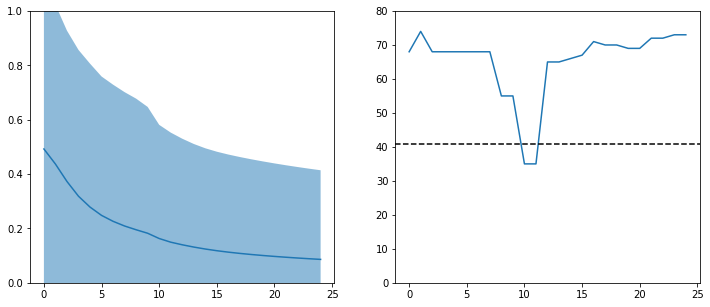

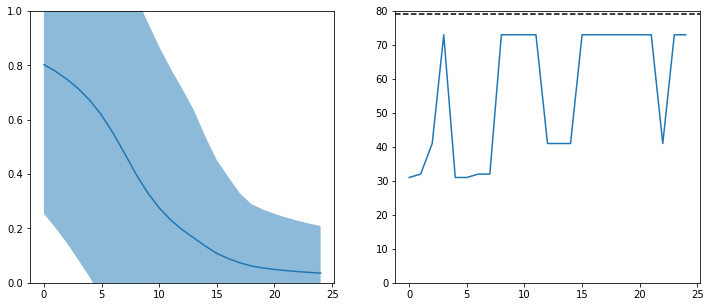

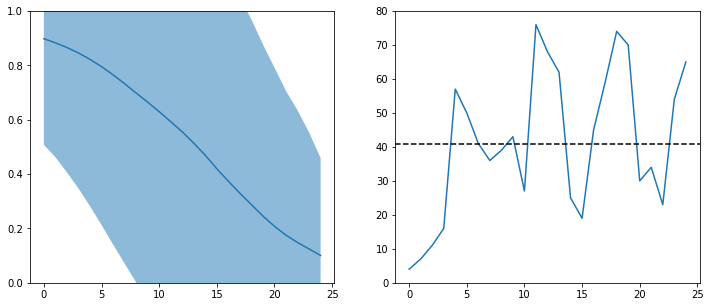

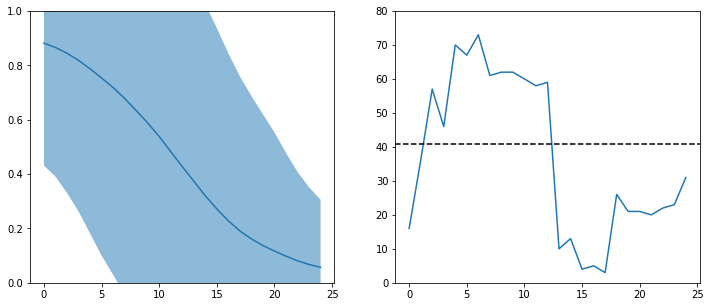

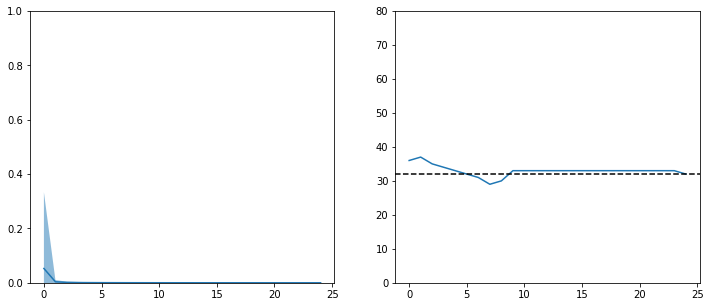

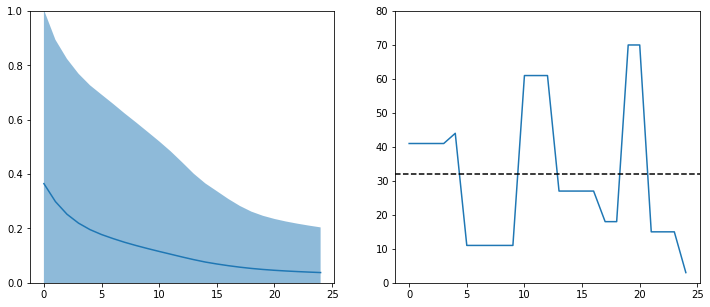

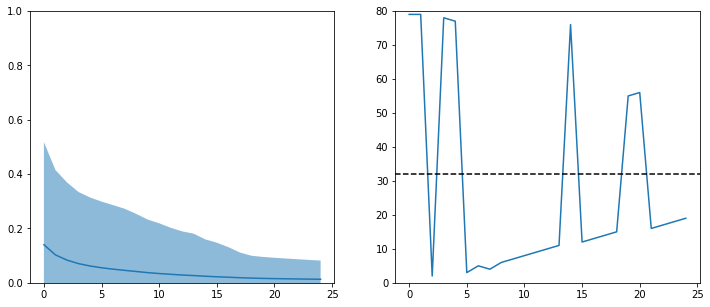

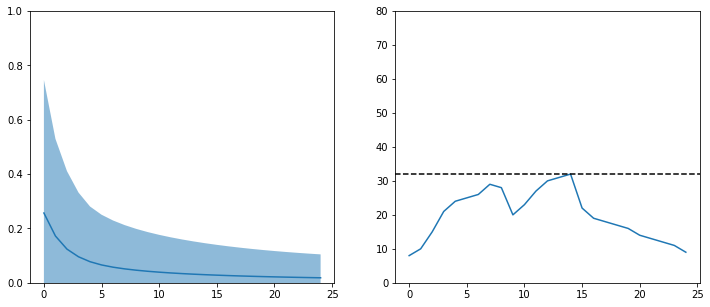

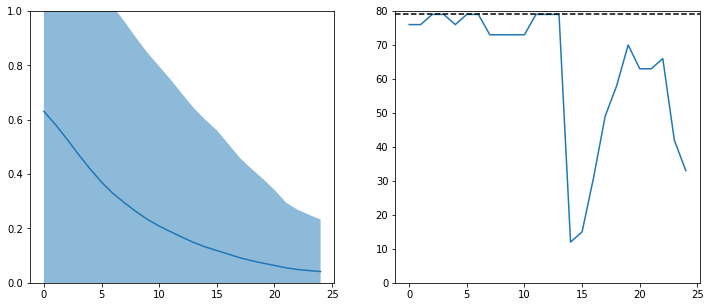

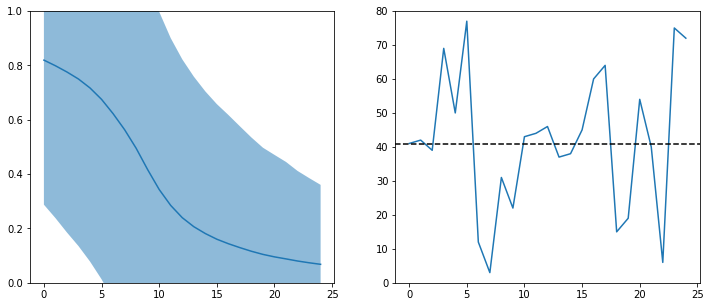

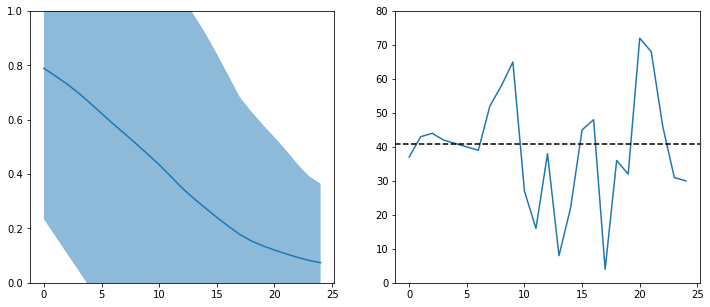

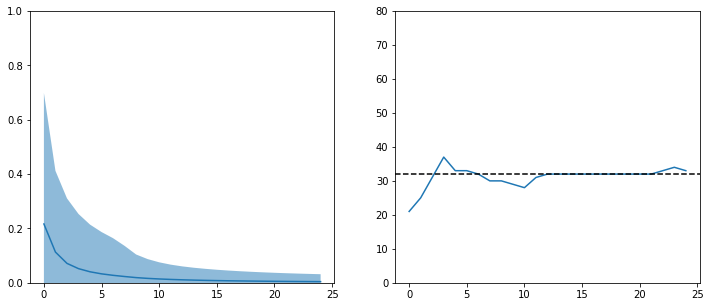

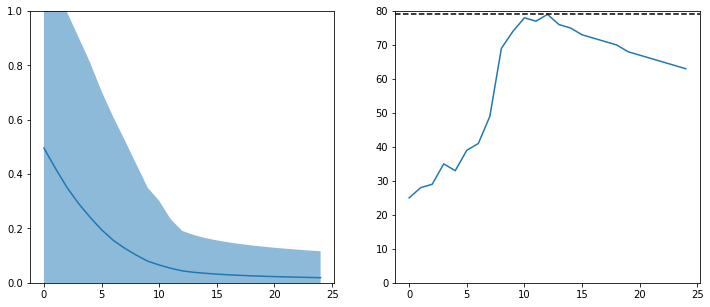

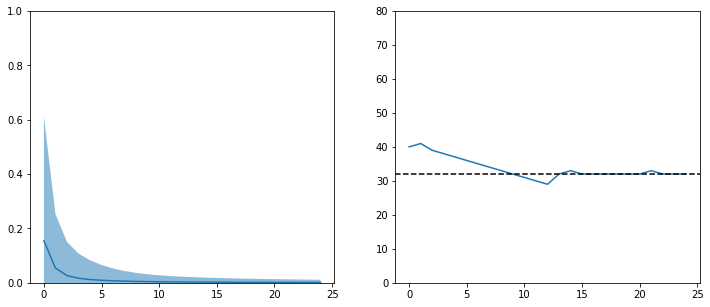

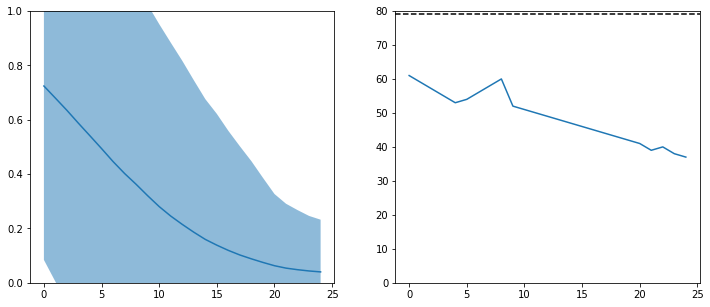

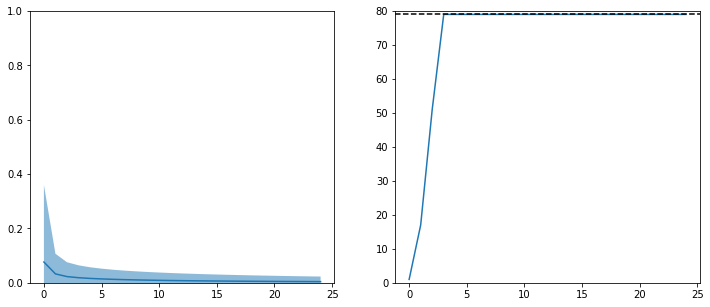

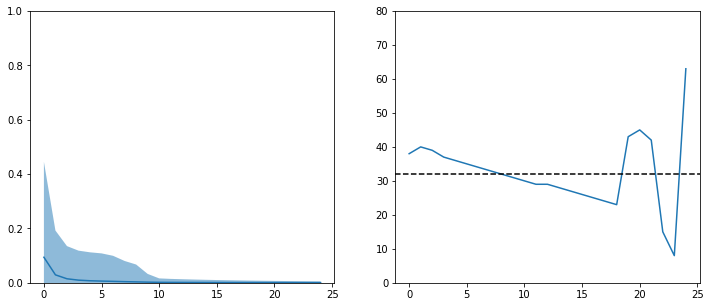

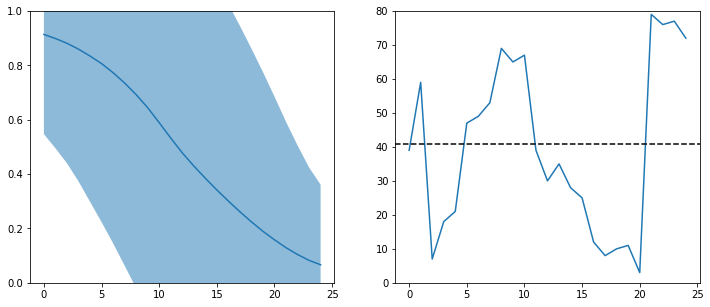

In [89]:
for i in range(len(means)):
    m = means.loc[i][['trial_'+str(i) for i in range(len(actions.T))]]
    s = stds.loc[i][['trial_'+str(i) for i in range(len(actions.T))]]
    upper = m.values + 2*s.values
    lower = m.values - 2*s.values
    fmax = np.array(functions_dict[function_conditions[i]]).argmax()    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.plot(m.values);
    ax1.fill_between(np.arange(len(m)), lower, upper, alpha=.5)
    ax2.plot(actions[i])
    ax2.axhline(fmax, ls='--', c='black')
    ax1.set_ylim([0, 1])
    ax2.set_ylim([0, 80])
    plt.show()